## Imports

In [45]:
# Standard libraries
import os
from typing import Optional

# Data processing and scientific computing
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning: Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRFClassifier, plot_tree, plot_importance

# Machine Learning: Model evaluation and preprocessing
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Audio processing libraries
import librosa
import librosa.display
import openl3
import soundfile as sf

# TensorFlow & Keras for Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Activation, Bidirectional, Conv2D, Dense, Dropout, Flatten, GRU, Input, LSTM, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

# Keras specific
import keras
from keras.layers import Embedding, Lambda
from keras.models import Model, Sequential


In [46]:
dict_moods = {'happy': 0, 'sad': 1, 'angry': 2, 'in-love': 3}

In [69]:
def remove_duplicates(data_ini: pd.DataFrame) -> pd.DataFrame:
    """
    Removes duplicate rows from a DataFrame based on the 'Song ID' column.
    """
    data = pd.DataFrame(columns=data_ini.columns)

    for index, row in data_ini.iterrows():
        if row['Song ID'] not in data['Song ID'].values:
            data = data.append(row)

    data.reset_index(drop=True, inplace=True)
    
    return data

def normalize_to_same_scale(data_i: pd.DataFrame) -> pd.DataFrame:
    """
    Normalizes the numerical columns of a DataFrame to have a mean of 0 and a standard deviation of 1.
    
    Returns:
    - pd.DataFrame: The normalized DataFrame.
    """
    std_scaler = StandardScaler()
    np_scaled = std_scaler.fit_transform(data_i) 
    return pd.DataFrame(np_scaled, columns = data_i.columns)

def adding_number_label_column(data: pd.DataFrame, original_label_column: str = "Emotion", new_label_column: str = "label",
                              mapping_dict: dict[str, int] = {'happy': 0, 'sad': 1, 'angry': 2, 'in-love': 3}) -> pd.DataFrame:   
    """
    Adds a new column to the DataFrame with numerical labels based on mapping from another column's values.
    """  
    # Replace values in the 'Emotion' column using the dictionary and map as a int number representaion.
    data[new_label_column] = data[original_label_column].str.lower().map(mapping_dict)
    return data.dropna(subset=[new_label_column])   

def prepare_data(data_i: pd.DataFrame, label_column: str = "label", columns_to_exclude: List[str] = []) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Prepares the data for modeling by separating labels from features and normalizing the features.
    """
    labels = data_i[label_column]
    features_data = data_i.drop(columns=[label_column] + columns_to_exclude)
    features_data = normalize_to_same_scale(features_data)
    return features_data, labels
    
def model_fit_and_predict(model, X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series, model_name: str = "", 
                          print_classification_report: bool = False, print_confusion_matrix: bool = False) -> None:
    """
    Fits a model to the training data and makes predictions on the test data, with optional printing of classification report and confusion matrix.
    """
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    if print_confusion_matrix:
        print(confusion_matrix(y_test, preds))
    
    if print_classification_report:
        print(classification_report(y_test, preds, target_names=dict_moods.keys()))
        
    print('Accuracy', model_name, ':', round(accuracy_score(y_test, preds), 5), '\n')
    
def print_confusion_matrix(y_test, y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred)

    # Normalize confusion matrix
    cf_matrix_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot heatmap
    sns.heatmap(cf_matrix_normalized, square=True, annot=True, fmt='.2f', cbar=False,
                xticklabels=dict_moods.keys(),
                yticklabels=dict_moods.keys())
    plt.xlabel('True label', fontsize=14)
    plt.ylabel('Predicted label', fontsize=14)
    plt.title('Normalized Confusion Matrix', fontsize=16)
    plt.show()
    
def get_and_print_classification_report(model, X_test, y_test):    
    y_true = np.argmax(y_test, axis = 1)
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    print(classification_report(y_true, y_pred, target_names=dict_moods.keys()))
    return y_true, y_pred

In [4]:
def run_classic_ml_models(X_train, X_test, y_train, y_test, use_knn = False,
                          print_classification_report: bool = False, print_confusion_matrix: bool = False):
    
    # Naive Base
    nb = GaussianNB()
    model_fit_and_predict(nb, X_train, X_test, y_train, y_test, "Naive Bayes", 
                          print_classification_report, print_confusion_matrix)
    
    # Stochastic Gradient Descent
    sgd = SGDClassifier(max_iter=5000, random_state=0)
    model_fit_and_predict(sgd, X_train, X_test, y_train, y_test, "Stochastic Gradient Descent", 
                          print_classification_report, print_confusion_matrix)
    
    # KNN
    if use_knn:
        knn = KNeighborsClassifier(n_neighbors=10)
        model_fit_and_predict(knn, X_train, X_test, y_train, y_test, "KNN", 
                              print_classification_report, print_confusion_matrix)
    
    # Decission trees
    tree = DecisionTreeClassifier()
    model_fit_and_predict(tree, X_train, X_test, y_train, y_test, "Decission trees", 
                          print_classification_report, print_confusion_matrix)
    
    # Random Forest
    rforest = RandomForestClassifier(n_estimators=500, max_depth=8, random_state=42)
    model_fit_and_predict(rforest, X_train, X_test, y_train, y_test, "Random Forest", 
                          print_classification_report, print_confusion_matrix)
    
    # Support Vector Machine
    svm = SVC(decision_function_shape="ovo")
    model_fit_and_predict(svm, X_train, X_test, y_train, y_test, "Support Vector Machine", 
                          print_classification_report, print_confusion_matrix)
    
    # Logistic Regression
    lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
    model_fit_and_predict(lg, X_train, X_test, y_train, y_test, "Logistic Regression", 
                          print_classification_report, print_confusion_matrix)
    
    # Neural Nets
    nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
    model_fit_and_predict(nn, X_train, X_test, y_train, y_test, "Neural Nets", 
                          print_classification_report, print_confusion_matrix)
    
    # Cross Gradient Booster
    xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
    model_fit_and_predict(xgb, X_train, X_test, y_train, y_test, "Cross Gradient Booster", 
                          print_classification_report, print_confusion_matrix)
    
    # Cross Gradient Booster (Random Forest)
    xgbrf = XGBRFClassifier(objective= 'multi:softmax')
    model_fit_and_predict(xgbrf, X_train, X_test, y_train, y_test, "Cross Gradient Booster (Random Forest)", 
                          print_classification_report, print_confusion_matrix)

In [48]:
all_non_features_columns = ['Song ID', 'Song Name', 'Artist', 'Length', 'Spectrogram Path'] #, 'Lyrics']
spotify_all_columns = ["Danceability", "Energy", "Key", "Loudness", "Mode", "Speechiness", "Acousticness", "Instrumentalness", "Liveness", "Valence", "Tempo", "Time Signature"]
roberta_all_columns = ["sadness_score", "neutral_score", "disappointment_score", "annoyance_score", "realization_score", "disapproval_score", "curiosity_score", "nervousness_score", "anger_score", "confusion_score", "approval_score", "grief_score", "amusement_score", "caring_score", "remorse_score", "embarrassment_score", "joy_score", "disgust_score", "optimism_score", "desire_score", "fear_score", "surprise_score", "relief_score", "love_score", "admiration_score", "excitement_score", "pride_score", "gratitude_score"]

## Classic ML on spotify features

In [6]:
# Reading Data
data_ini = pd.read_csv(f'data_with_lyrics_class.csv')
data_ini.head()

,Song ID,Song Name,Artist,Length,Danceability,Energy,Key,Loudness,Mode,Speechiness,...,desire_score,fear_score,surprise_score,relief_score,love_score,admiration_score,excitement_score,pride_score,gratitude_score,Emotion
0,3hRV0jL3vUpRrcy398teAU,The Night We Met,Lord Huron,208211,0.544,0.369,2,-9.514,1,0.0380,...,0.002927,0.061406,0.021120,0.001892,0.001701,0.000661,0.002004,0.000505,0.001042,sad
1,3hRV0jL3vUpRrcy398teAU,The Night We Met,Lord Huron,208211,0.544,0.369,2,-9.514,1,0.0380,...,0.002927,0.061406,0.021120,0.001892,0.001701,0.000661,0.002004,0.000505,0.001042,sad
2,3hRV0jL3vUpRrcy398teAU,The Night We Met,Lord Huron,208211,0.544,0.369,2,-9.514,1,0.0380,...,0.002927,0.061406,0.021120,0.001892,0.001701,0.000661,0.002004,0.000505,0.001042,sad
3,0mflMxspEfB0VbI1kyLiAv,Stick Season,Noah Kahan,182346,0.662,0.488,9,-6.894,1,0.0682,...,0.040197,0.179270,0.023288,0.003167,0.564811,0.004089,0.007492,0.001954,0.000539,sad
4,0mflMxspEfB0VbI1kyLiAv,Stick Season,Noah Kahan,182346,0.662,0.488,9,-6.894,1,0.0682,...,0.040197,0.179270,0.023288,0.003167,0.564811,0.004089,0.007492,0.001954,0.000539,sad


In [ ]:
data = remove_duplicates(data_ini)
data = adding_number_label_column(data)
data = data.drop(columns=["Emotion"])

In [8]:
# prepare data
features_spotify, labels_spotify = prepare_data(data, label_column="label", columns_to_exclude=all_non_features_columns + roberta_all_columns)
print(f"spotify features are {features_spotify.shape}")
features_roberta, labels_roberta = prepare_data(data, label_column="label", columns_to_exclude=all_non_features_columns + spotify_all_columns)
print(f"roberta features are {features_roberta.shape}")
features_all, labels_all = prepare_data(data, label_column="label", columns_to_exclude=all_non_features_columns)
print(f"all features are {features_all.shape}")

spotify features are (410, 12)
roberta features are (410, 28)
all features are (410, 40)


In [9]:
# Spotify features:
X_train, X_test, y_train, y_test = train_test_split(features_spotify, labels_spotify, test_size=0.2, random_state=42, shuffle=True, stratify=labels_spotify)
run_classic_ml_models(X_train, X_test, y_train, y_test, True)

Accuracy Naive Bayes : 0.5122 

Accuracy Stochastic Gradient Descent : 0.54878 

Accuracy KNN : 0.57317 

Accuracy Decission trees : 0.62195 

Accuracy Random Forest : 0.62195 

Accuracy Support Vector Machine : 0.63415 

Accuracy Logistic Regression : 0.63415 

Accuracy Neural Nets : 0.60976 

Accuracy Cross Gradient Booster : 0.67073 

Accuracy Cross Gradient Booster (Random Forest) : 0.68293 



In [10]:
# roberta-base-go_emotions features:
X_train, X_test, y_train, y_test = train_test_split(features_roberta, labels_roberta, test_size=0.2, random_state=42, shuffle=True, stratify=labels_roberta)
run_classic_ml_models(X_train, X_test, y_train, y_test)

Accuracy Naive Bayes : 0.45122 

Accuracy Stochastic Gradient Descent : 0.46341 

Accuracy Decission trees : 0.35366 

Accuracy Random Forest : 0.43902 

Accuracy Support Vector Machine : 0.5 

Accuracy Logistic Regression : 0.4878 

Accuracy Neural Nets : 0.37805 

Accuracy Cross Gradient Booster : 0.43902 

Accuracy Cross Gradient Booster (Random Forest) : 0.4878 



In [11]:
# Spotify + roberta-base-go_emotions features:
X_train, X_test, y_train, y_test = train_test_split(features_all, labels_all, test_size=0.2, random_state=42, shuffle=True, stratify=labels_roberta)
run_classic_ml_models(X_train, X_test, y_train, y_test)

Accuracy Naive Bayes : 0.64634 

Accuracy Stochastic Gradient Descent : 0.65854 

Accuracy Decission trees : 0.60976 

Accuracy Random Forest : 0.69512 

Accuracy Support Vector Machine : 0.67073 

Accuracy Logistic Regression : 0.71951 

Accuracy Neural Nets : 0.65854 

Accuracy Cross Gradient Booster : 0.7439 

Accuracy Cross Gradient Booster (Random Forest) : 0.71951 



## Cross Gradient Booster is the winning here:

In [12]:
# Cross Gradient Booster (Random Forest)
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print(y_test.shape, y_pred.shape)
print(classification_report(y_test, y_pred, target_names=dict_moods.keys()))

(82,) (82,)
              precision    recall  f1-score   support

       happy       0.71      0.71      0.71        14
         sad       0.71      0.86      0.77        28
       angry       0.84      0.80      0.82        20
     in-love       0.73      0.55      0.63        20

    accuracy                           0.74        82
   macro avg       0.75      0.73      0.73        82
weighted avg       0.75      0.74      0.74        82



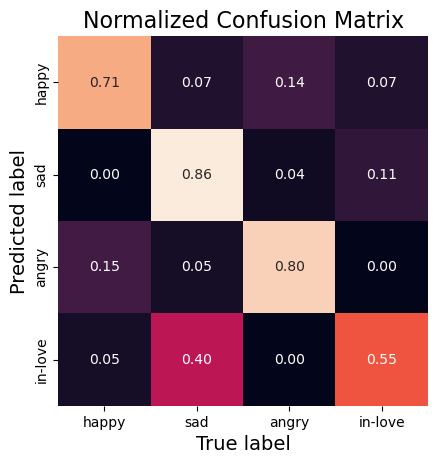

In [13]:
print_confusion_matrix(y_test, y_pred)

# Extract OpenL3 embedding and add network as a post-process:

### Helper Functions:

In [49]:
def extract_features(audio_path: str) -> np.ndarray:
    """
    Extracts audio embeddings from a given audio file path using the OpenL3 library.
    """
    audio, sr = sf.read(audio_path)
    embedding, ts = openl3.get_audio_embedding(audio, sr, input_repr="mel256", embedding_size=512)
    return embedding

def edit_path(path: str) -> str:
    dir_name, file_name = os.path.split(path)
    return f"./data_with_wav/openl3_embedding/{file_name}"

def get_embedding(path: str) -> Optional[np.ndarray]:
    """
    Attempts to extract features from an audio file; returns None if the file does not exist.
    """
    if os.path.exists(path):
        return extract_features(path)
    else:
        return None
    
def load_npy(path: str) -> Optional[np.ndarray]:
    """
    Loads a .npy file if it exists; returns None otherwise.
    """
    if os.path.exists(path):
        return np.load(path)
    else:
        return None
    
def load_npy_mean(path: str) -> Optional[np.ndarray]:
    """
    Loads a .npy file and returns its mean along axis 0; returns None if the file does not exist.
    """
    if os.path.exists(path):
        np_array = np.load(path)
        return np.mean(np_array, axis=0)
    else:
        return None
    
# Function to load npy file
def validate_size_2d(np_data: Optional[np.ndarray]) -> Optional[np.ndarray]:
    """
    Validates if the input numpy array has the shape (196, 512); returns None otherwise.
    """
    if np_data is not None:
        if np_data.shape == (196, 512):
            return np_data
        else:
            return None
    else:
        return None
    
# Function to load npy file
def validate_size_1d(np_data: Optional[np.ndarray]) -> Optional[np.ndarray]:
    """
    Validates if the input numpy array has the shape (512,); returns None otherwise.
    """
    if np_data is not None:
        if np_data.shape == (512, ):
            return np_data
        else:
            return None
    else:
        return None

def get_bit_represent_labels(data: pd.DataFrame, label_column: str = 'label', num_categories: int = 4) -> np.ndarray:
    """
    Converts categorical labels in a DataFrame into a bit encoded numpy array.
    """
    return np.eye(num_categories)[data[label_column]]

def convert_column_into_np_array(data: pd.DataFrame, column: str = 'Npy Content') -> np.ndarray:
    """
    Converts a column in a DataFrame containing numpy arrays into a single stacked numpy array.
    """
    numpy_arrays = []

    for element in data[column]:
        numpy_arrays.append(element)

    return np.stack(numpy_arrays)

def train_validation_test_split(features: np.ndarray, labels: np.ndarray, test_size: float = 0.3, random_state: int = 42) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Splits the features and labels into training, validation, and test sets.
    """
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=random_state, stratify=labels)
    X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
    return X_train, X_validation, X_test, y_train, y_validation, y_test

def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    
def build_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(196, 512, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'), # 512
        layers.Dense(4, activation='softmax')
    ])

    model.summary()
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

def build_fully_connected_model():
    model = models.Sequential([    
        layers.Input(shape=(512, 1)),  # Explicitly defining input shape
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(4, activation='softmax')
    ])

    model.summary()
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

## embedding matrix:
### Take the all embedding output of the openl3 and try to build cnn as a post-network model

In [62]:
# Reading Data
openl3_data = pd.read_csv(f'embeddings_data.csv')
openl3_data.head()

,npy_path,emotion
0,./data_with_wav\openl3_embedding\i_was_all_ove...,sad
1,./data_with_wav\openl3_embedding\i_was_all_ove...,sad
2,./data_with_wav\openl3_embedding\i_was_all_ove...,sad
3,./data_with_wav\openl3_embedding\Inside_Out_0.npy,sad
4,./data_with_wav\openl3_embedding\Inside_Out_1.npy,sad


In [63]:
# Prepare data:
# Adding label as int number
openl3_data = adding_number_label_column(openl3_data, original_label_column="emotion")
# edit the path to be correct to the path in my computer
openl3_data['npy_path'] = openl3_data['npy_path'].apply(edit_path)
# load the np data from the files
openl3_data['Npy Content'] = openl3_data['npy_path'].apply(load_npy)
# leave only ['Npy Content', 'label'] columns
openl3_data = openl3_data[['Npy Content', 'label']]
# validate the shape and leave only the "valid" once
openl3_data['Npy Content'] = openl3_data['Npy Content'].apply(validate_size_2d)
openl3_data = openl3_data.dropna(subset=["Npy Content"])

In [64]:
# extract the features and labels for the 2d representaion
features_2d = convert_column_into_np_array(openl3_data, 'Npy Content')
labels_2d = get_bit_represent_labels(openl3_data)

### Build CNN as a post network for the openl3 embedding

In [66]:
X_train, X_validation, X_test, y_train, y_validation, y_test = train_validation_test_split(features_2d, labels_2d)

model = build_cnn_model()

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint('model_checkpoint.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=10,  
    batch_size=50,
    validation_data=(X_validation, y_validation),
    callbacks=[checkpoint]
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 194, 510, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 97, 255, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 95, 253, 64)       18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 47, 126, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 124, 128)      73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 22, 62, 128)      

C:\Users\Yonatan Ron\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 142s 4s/step - loss: 4.3909 - accuracy: 0.3153 - val_loss: 1.3675 - val_accuracy: 0.2317
Epoch 2/10
32/32 [==============================] - ETA: 0s - loss: 1.2799 - accuracy: 0.3965
Epoch 2: val_loss improved from 1.36749 to 1.14989, saving model to model_checkpoint.h5
32/32 [==============================] - 135s 4s/step - loss: 1.2799 - accuracy: 0.3965 - val_loss: 1.1499 - val_accuracy: 0.4516
Epoch 3/10
32/32 [==============================] - ETA: 0s - loss: 1.0893 - accuracy: 0.5142
Epoch 3: val_loss improved from 1.14989 to 1.03602, saving model to model_checkpoint.h5
32/32 [==============================] - 137s 4s/step - loss: 1.0893 - accuracy: 0.5142 - val_loss: 1.0360 - val_accuracy: 0.5455
Epoch 4/10
32/32 [==============================] - ETA: 0s - loss: 0.9980 - accuracy: 0.5765
Epoch 4: val_loss did not improve from 1.03602
32/32 [==============================] - 140s 4s/step - loss: 0.9980 - accuracy: 0.5765 - val_loss: 1.036

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


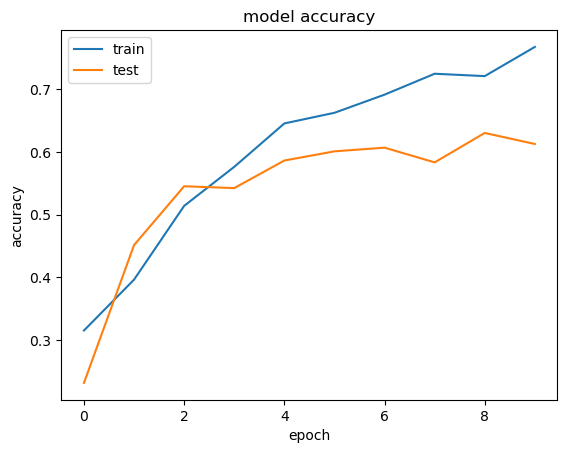

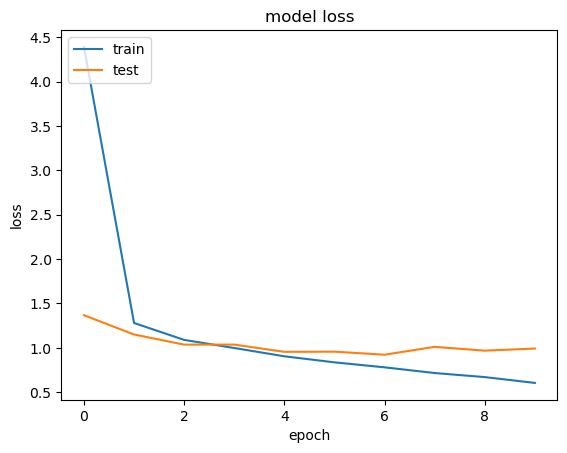

In [67]:
show_summary_stats(history)

In [72]:
y_true, y_pred = get_and_print_classification_report(model, X_test, y_test)

11/11 [==============================] - 5s 416ms/step
              precision    recall  f1-score   support

       happy       0.47      0.82      0.60        83
         sad       0.64      0.60      0.62        91
       angry       0.76      0.41      0.53        78
     in-love       0.70      0.54      0.61        89

    accuracy                           0.60       341
   macro avg       0.64      0.59      0.59       341
weighted avg       0.64      0.60      0.59       341



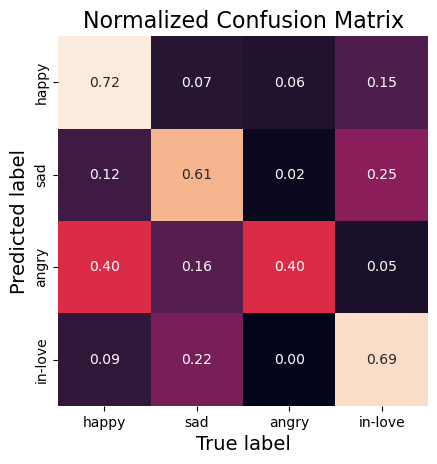

In [71]:
print_confusion_matrix(y_true, y_pred)

## Single embedding vector:
### The idea is to take the 2d representaion and convert it to 1d of the embedding from openl3

In [51]:
# Reading Data
openl3_data_embedding = pd.read_csv(f'embeddings_data.csv')
openl3_data_embedding.head()

,npy_path,emotion
0,./data_with_wav\openl3_embedding\i_was_all_ove...,sad
1,./data_with_wav\openl3_embedding\i_was_all_ove...,sad
2,./data_with_wav\openl3_embedding\i_was_all_ove...,sad
3,./data_with_wav\openl3_embedding\Inside_Out_0.npy,sad
4,./data_with_wav\openl3_embedding\Inside_Out_1.npy,sad


In [52]:
# Prepare data:
# Adding label as int number
openl3_data_embedding = adding_number_label_column(openl3_data_embedding, original_label_column="emotion")
# edit the path to be correct to the path in my computer
openl3_data_embedding['npy_path'] = openl3_data_embedding['npy_path'].apply(edit_path)
# load the np data from the files, it will take the 196 samples of 512 embeddings and create the mean vector.
openl3_data_embedding['Npy Content'] = openl3_data_embedding['npy_path'].apply(load_npy_mean)
openl3_data_embedding = openl3_data_embedding[['Npy Content', 'label']]

In [53]:
features_mean_embedding = convert_column_into_np_array(openl3_data_embedding, 'Npy Content')
labels = get_bit_represent_labels(openl3_data_embedding)

In [58]:
X_train, X_validation, X_test, y_train, y_validation, y_test = train_validation_test_split(features_mean_embedding, labels)

model = build_fully_connected_model()

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint('model_checkpoint.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=50,  
    batch_size=100,
    validation_data=(X_validation, y_validation),
    callbacks=[checkpoint]  # Add checkpoint, scheduler callbacks
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 264708 (1.01 MB)
Trainable params: 264708 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
11/16 [===================>..........] - ETA: 0s - loss: 4.1718 - accuracy: 0.2482
Epoch 1: val_loss improved from inf to 2.59542, saving model to model_checkpoint.h5
16/16 [==============================] - 1s 19ms/step - loss: 3.5550 - accuracy: 0.2564 - val_loss: 2.59

C:\Users\Yonatan Ron\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3/50
 9/16 [===============>..............] - ETA: 0s - loss: 1.2764 - accuracy: 0.4033
Epoch 3: val_loss improved from 1.38706 to 1.13625, saving model to model_checkpoint.h5
16/16 [==============================] - 0s 11ms/step - loss: 1.2449 - accuracy: 0.4136 - val_loss: 1.1362 - val_accuracy: 0.4428
Epoch 4/50
10/16 [=================>............] - ETA: 0s - loss: 1.1529 - accuracy: 0.5000
Epoch 4: val_loss improved from 1.13625 to 1.09216, saving model to model_checkpoint.h5
16/16 [==============================] - 0s 10ms/step - loss: 1.1441 - accuracy: 0.4972 - val_loss: 1.0922 - val_accuracy: 0.5073
Epoch 5/50
 8/16 [==============>...............] - ETA: 0s - loss: 1.1407 - accuracy: 0.4950
Epoch 5: val_loss improved from 1.09216 to 1.04373, saving model to model_checkpoint.h5
16/16 [==============================] - 0s 12ms/step - loss: 1.1275 - accuracy: 0.5009 - val_loss: 1.0437 - val_accuracy: 0.5572
Epoch 6/50
10/16 [=================>............] - ETA: 0s - lo

Epoch 32/50
10/16 [=================>............] - ETA: 0s - loss: 0.9762 - accuracy: 0.6050
Epoch 32: val_loss did not improve from 0.87692
16/16 [==============================] - 0s 8ms/step - loss: 0.9492 - accuracy: 0.6072 - val_loss: 0.9586 - val_accuracy: 0.5982
Epoch 33/50
11/16 [===================>..........] - ETA: 0s - loss: 0.9584 - accuracy: 0.6009
Epoch 33: val_loss did not improve from 0.87692
16/16 [==============================] - 0s 8ms/step - loss: 0.9680 - accuracy: 0.6028 - val_loss: 1.0859 - val_accuracy: 0.5191
Epoch 34/50
10/16 [=================>............] - ETA: 0s - loss: 0.8746 - accuracy: 0.6490
Epoch 34: val_loss did not improve from 0.87692
16/16 [==============================] - 0s 8ms/step - loss: 0.8922 - accuracy: 0.6380 - val_loss: 0.9699 - val_accuracy: 0.5572
Epoch 35/50
10/16 [=================>............] - ETA: 0s - loss: 0.8969 - accuracy: 0.6200
Epoch 35: val_loss did not improve from 0.87692
16/16 [==============================] - 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


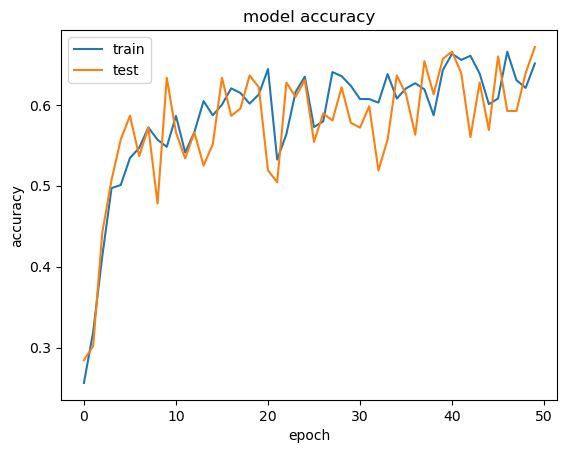

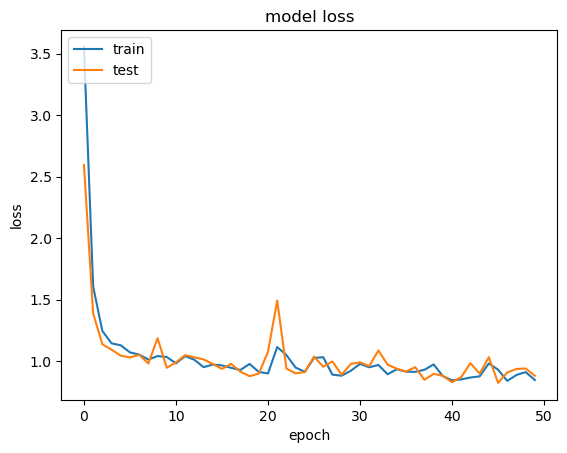

In [59]:
show_summary_stats(history)

In [60]:
y_true, y_pred = get_and_print_classification_report(model, X_test, y_test)

11/11 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       happy       0.53      0.72      0.61        81
         sad       0.60      0.61      0.61        93
       angry       0.82      0.40      0.53        81
     in-love       0.61      0.69      0.65        87

    accuracy                           0.61       342
   macro avg       0.64      0.60      0.60       342
weighted avg       0.64      0.61      0.60       342



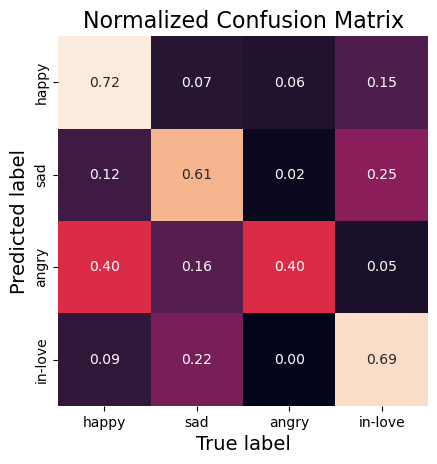

In [61]:
print_confusion_matrix(y_true, y_pred)

### Try the classic ml models on the embedding from openl3 as features.

In [40]:
df_features = pd.DataFrame(features_mean_embedding.tolist())
X_train, X_test, y_train, y_test = train_test_split(df_features, openl3_data_embedding['label'], test_size=0.2, random_state=42) #, shuffle=True, stratify=openl3_data['label'])
run_classic_ml_models(X_train, X_test, y_train, y_test)

Accuracy Naive Bayes : 0.59341 

Accuracy Stochastic Gradient Descent : 0.51868 

Accuracy Decission trees : 0.52308 

Accuracy Random Forest : 0.69231 

Accuracy Support Vector Machine : 0.68352 



C:\Users\Yonatan Ron\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Logistic Regression : 0.66593 



C:\Users\Yonatan Ron\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy Neural Nets : 0.7011 

Accuracy Cross Gradient Booster : 0.75165 

Accuracy Cross Gradient Booster (Random Forest) : 0.6967 

